## Segmentation experiments

In [2]:
import time
import cv2
import os
import pytesseract
from pytesseract import Output
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
#from deslant_img import deslant_img
import imutils

from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Hyperparameters
confidence_threshold = 60
width_tolerance = 0.3
min_entry_width = 10
max_entry_width = 250

# Parameters
input_dir = "Dataset/Ownership/jpg"
output_dir = "Dataset/Ownership/ocr/"
cropped_dir = "Dataset/Ownership/cropped"
log_dir = "Dataset/Ownership/"

TODO:
- Cases where building is not detected
- Test stability for more images

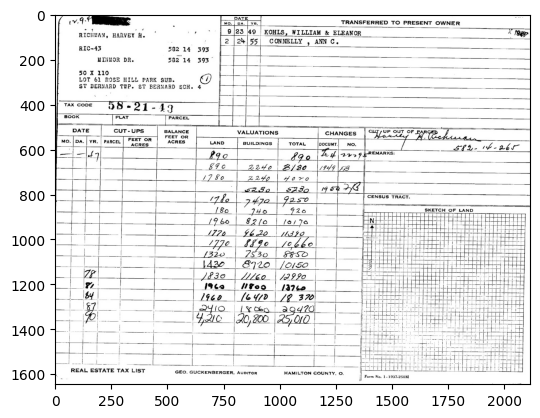

In [15]:
img = cv2.imread(f'{cropped_dir}/5820014039300.jpg')

#img = cv2.imread(f'{cropped_dir}/6120010010700.jpg')



plt.imshow(img)

In [16]:
# Get locations of the text from Pytesseract
d = pytesseract.image_to_data(img, output_type=Output.DICT)

building_index, total_index, land_index, valuation_index = -999, -999, -999, -999

for index, text in enumerate(d['text']):
    if text.lower() == "buildings":
        building_index = index
    if text.lower() == "total":
        total_index = index
    if text.lower() == 'land':
        land_index = index
    if text.lower() == 'valuations':
        valuation_index = index

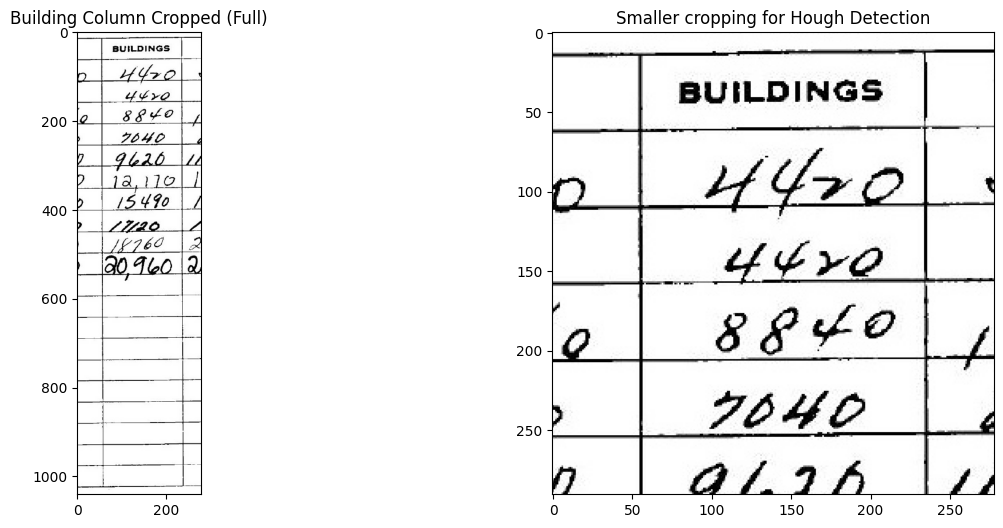

In [16]:
# Crop image if building found
if building_index != -999:

    b = building_index

    width_param_left = 80
    width_param_right = 150
    height_top_cut =15
    height_bottom_cut_col = 50
    height_bottom_cut_hough = 800 ## Note: hough transformation doesn't seem to work on larger image - it only finds the vertical and not the horizontal lines

    # Crop image to smaller set based on values 
    x0 = d['left'][b] - width_param_left
    x1 = x0 + d['width'][b] + width_param_right

    y0 = d['top'][b] - d['height'][b] - height_top_cut
    y1 = img.shape[0] - height_bottom_cut_hough

    y1_full = img.shape[0] - height_bottom_cut_col

    cropped_again = img[y0:y1, x0:x1]

    building_column_cropped = img[y0:y1_full, x0:x1]

    print(x0, x1, y0, y1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(building_column_cropped)
    ax[0].set_title('Building Column Cropped (Full)')
    ax[1].imshow(cropped_again)
    ax[1].set_title('Smaller cropping for Hough Detection')

else:
    print('building text not found')




Text(0.5, 1.0, 'Smaller cropping for Hough Detection')

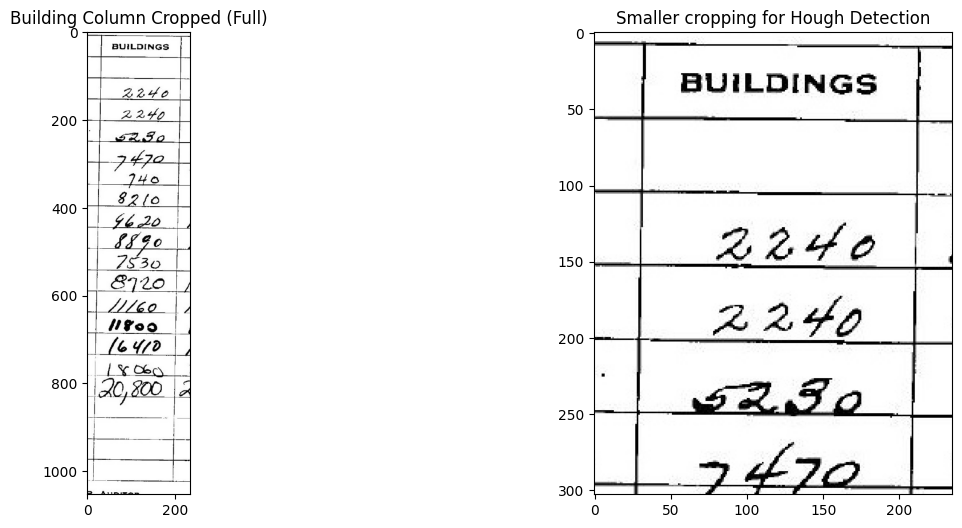

In [14]:
## Adjustment with total column

total_index

t = total_index

adjust_width = -180

width_param_left = 80
width_param_right = 160
height_top_cut = 15
height_bottom_cut_col = 50
height_bottom_cut_hough = 800 ## Note: hough transformation doesn't seem to work on larger image - it only finds the vertical and not the horizontal lines

# Crop image to smaller set based on values 
x0 = d['left'][t] + adjust_width - width_param_left
x1 = x0 + d['width'][t] + width_param_right

y0 = d['top'][t] - d['height'][t] - height_top_cut
y1 = img.shape[0] - height_bottom_cut_hough

y1_full = img.shape[0] - height_bottom_cut_col

cropped_again = img[y0:y1, x0:x1]

building_column_cropped = img[y0:y1_full, x0:x1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(building_column_cropped)
ax[0].set_title('Building Column Cropped (Full)')
ax[1].imshow(cropped_again)
ax[1].set_title('Smaller cropping for Hough Detection')

Text(0.5, 1.0, 'Smaller cropping for Hough Detection')

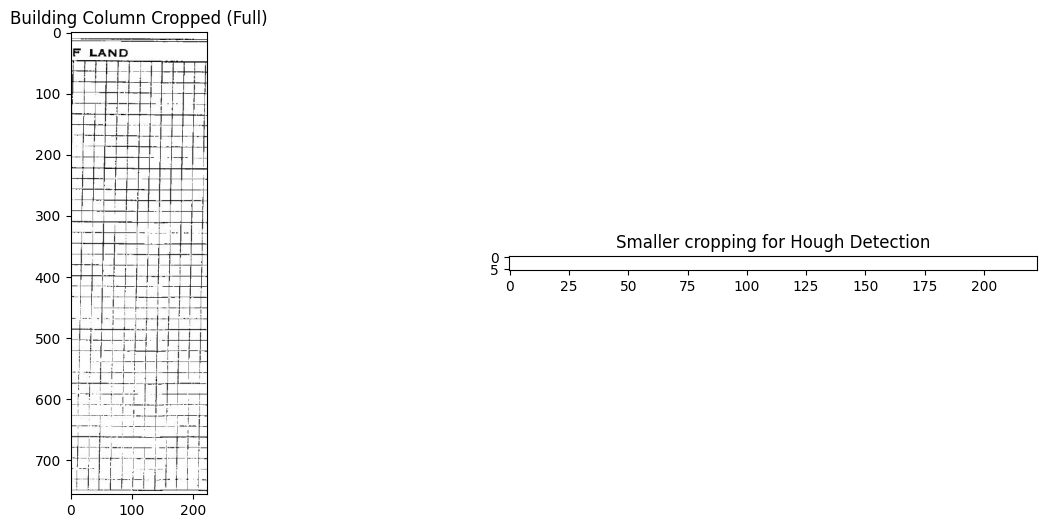

In [19]:
## Adjustment with land column
## Adjustment with total column

l = land_index

adjust_width = 50

width_param_left = 80
width_param_right = 160
height_top_cut = 15
height_bottom_cut_col = 50
height_bottom_cut_hough = 800 ## Note: hough transformation doesn't seem to work on larger image - it only finds the vertical and not the horizontal lines

# Crop image to smaller set based on values 
x0 = d['left'][l] + adjust_width - width_param_left
x1 = x0 + d['width'][l] + width_param_right

y0 = d['top'][l] - d['height'][l] - height_top_cut
y1 = img.shape[0] - height_bottom_cut_hough

y1_full = img.shape[0] - height_bottom_cut_col

cropped_again = img[y0:y1, x0:x1]

building_column_cropped = img[y0:y1_full, x0:x1]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(building_column_cropped)
ax[0].set_title('Building Column Cropped (Full)')
ax[1].imshow(cropped_again)
ax[1].set_title('Smaller cropping for Hough Detection')

12 lines were detected


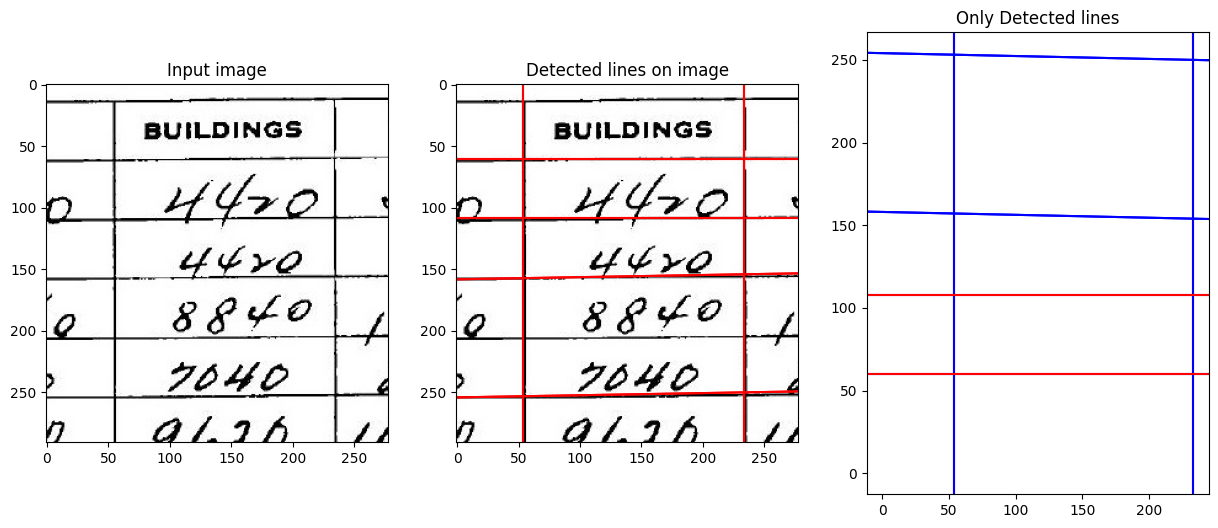

In [17]:
# Preprocessing for Hough
gray = cv2.cvtColor(cropped_again,cv2.COLOR_BGR2GRAY)
thresh, thresh_image = cv2.threshold(gray, 165, 255, cv2.THRESH_BINARY)
gray = cv2.convertScaleAbs(thresh_image) # converting the scale
edges = cv2.Canny(gray, 0, 200)

# Parameters
thresh = 10
min_distance = 20

# Perform hough transformation
dimx, dimy = edges.shape
#diagonal = np.sqrt(dimx**2 + dimy**2)
#thresh = int(thresh * diagonal)
tested_angles = np.linspace(-np.pi, np.pi, 360, endpoint = False)

# Apply hough lines to retrieve all possible lines
h, theta, d = hough_line(edges, theta = tested_angles)

hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)

# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(cropped_again)
ax[0].set_title('Input image')

ax[1].imshow(cropped_again)
ax[1].set_title('Detected lines on image')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, thresh, min_distance)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red')


ax[2].set_title('Only Detected lines')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, thresh, min_distance)):
    x = np.tan(angle + np.pi/2)

    # Horizontal lines
    if x >= 0:
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red')

    # vertical lines
    else:
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='blue')


hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)

num_lines = len(angles)

print(f"{num_lines} lines were detected")



C:\Users\mihir\AppData\Local\Temp\ipykernel_3612\2270708303.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0] # use lstsq to solve Ax = b, not inv() which is unstable


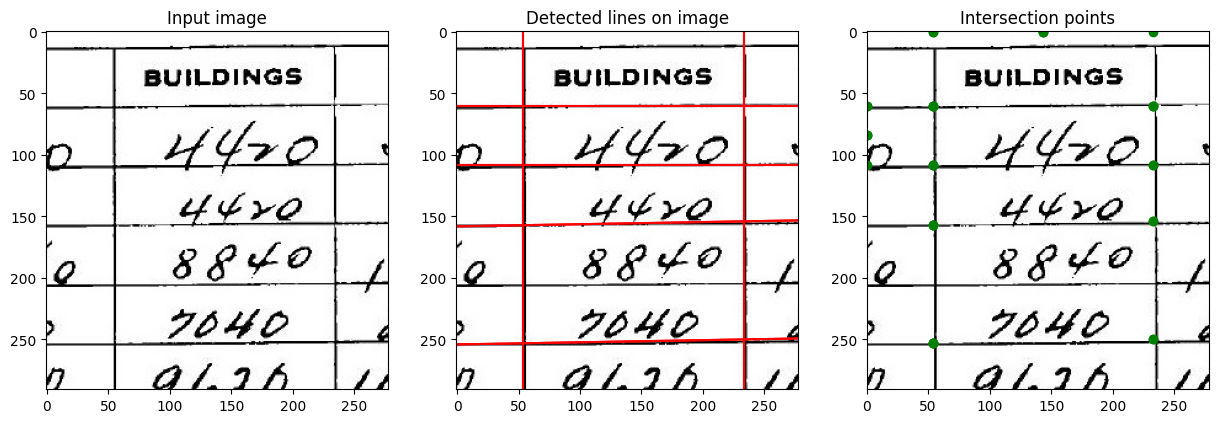

In [18]:
## Finding the intersection points

## First segment the lines into vertical vs horizontal, based on threshold system used above:
segmented = {}

hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)

for i in range(len(angles)):
    angle = angles[i]
    x = np.tan(angle + np.pi/2)
    if x >= 0:
        segmented[i] = 1 # horizontal line
    else:
        segmented[i] = 0 # vertical line


# Function sourced from this answer: https://stackoverflow.com/a/70371736

def hough_inter(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    
    return np.linalg.lstsq(A, b)[0] # use lstsq to solve Ax = b, not inv() which is unstable


# Now loop through all combinations of lines, only checking for intersections if they are of different types
intersections = []

for i in range(len(angles) - 1):
    for j in range(1, len(angles)):
        
        if segmented[i] != segmented[j]: # check that we are only running algo for vertical / horizontal line pairs
            
            point = hough_inter(angles[i], dists[i], angles[j], dists[j])

            intersections.append(point)

        else:
            pass


# Check 

# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(cropped_again)
ax[0].set_title('Input image')

ax[1].imshow(cropped_again)
ax[1].set_title('Detected lines on image')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, thresh, min_distance)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red')

# Intersection points
ax[2].imshow(cropped_again)
ax[2].set_title('Intersection points')
ax[2].set_xlim(0, cropped_again.shape[1])
#ax[2].set_ylim(0, cropped_again.shape[0])
for i in intersections:
    ax[2].scatter(i[0], i[1], color='green')


In [19]:
# Subset intersection points to only the relevant pixels that fall within the boundaries of the image
relevant_intersects = [[x[0], x[1]] for x in intersections if (x[0] >= 0 and x[0] <= cropped_again.shape[0]) and (x[1] >= 0 and x[1] <= cropped_again.shape[1])]
#relevant_intersects = [*set(relevant_intersects)] - drop dups, but doesn't work well because dups are actually small decimal places apart

from operator import itemgetter

# Sort by intersection points from top of image to bottom (sort on y axis)
relevant_intersects.sort(key = lambda x: x[1])
rinter = relevant_intersects

# Get differences between each intersection and the one before
x_ax_diffs = np.array([round(rinter[i+1][0] - rinter[i][0], 3) for i in range(len(rinter)-1)])
y_ax_diffs = np.array([round(rinter[i+1][1] - rinter[i][1], 3) for i in range(len(rinter)-1)])

#print(x)
print(x_ax_diffs)
print(y_ax_diffs)

[   0.    89.5    0.     0.    89.5    0.  -179.     0.     0.   179.
 -179.   -54.     0.   233.  -233.     0.     0.   233.  -179.     0.
    0.   179.  -233.   233.     0.  -179.     0.     0.     0.   179.
    0.  -179.     0.     0.     0. ]
[ 0.     0.     0.     0.     0.    60.     0.     0.     0.     0.
  0.     0.     0.     0.    24.     0.     0.    24.     0.     0.
  0.     0.     0.    45.957  0.     3.124  0.     0.     0.    92.89
  0.     3.124  0.     0.     0.   ]


Width
179.0
8
[-179.  179. -179. -179.  179. -179.  179. -179.]

Height
60.0
1
[60.    45.957]

Slant
3.1
2
[3.1 3.1]

Top left point: [53.999999999999986, 3.3065463576978526e-15]


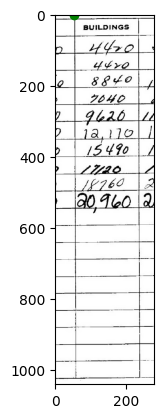

In [20]:
# Error tolerance
tolerance = 5

# TODO: set parameter on minimum number of cases to be detected; at least 4?

# Get width of box by looking at x_ax_diffs -> something within range of 150 - 250 difference
lower_bound_width = 150
upper_bound_width = 200

width_candidates = x_ax_diffs[(abs(x_ax_diffs) >= lower_bound_width) & (abs(x_ax_diffs) <= upper_bound_width)]

w_final = np.max(abs(width_candidates))

# Check that many values fall close to this:
close_count_w = len(width_candidates[np.where(abs(abs(width_candidates) - w_final) < tolerance)])

print('Width')
print(w_final)
print(close_count_w)
print(width_candidates)

# Get height of box by looking at diff in y_axis between 30-60 
lower_bound_height = 35
upper_bound_height = 60

height_candidates = y_ax_diffs[(abs(y_ax_diffs) >= lower_bound_height) & (abs(y_ax_diffs) <= upper_bound_height)]

h_final = np.max(abs(height_candidates))

close_count_h = len(height_candidates[np.where(abs(abs(height_candidates) - h_final) < tolerance)])

print('\nHeight')
print(h_final)
print(close_count_h)
print(height_candidates)

# Get the slant by seeing a consistent height difference where abs(x) < 5 and x != 0 - difference in y-axis 

## Slant
y_ax_slant = np.round(y_ax_diffs, 1)

slant_candidates = y_ax_slant[(abs(y_ax_slant) < 5) & (y_ax_slant != 0)]

slant_final = np.max(slant_candidates) # not absolute value because slant can either be positive or negative

close_count_s = len(slant_candidates[np.where(abs(slant_candidates) - abs(slant_final) < tolerance)])

print('\nSlant')
print(slant_final)
print(close_count_s)
print(slant_candidates)

# Top-left corner pixel coordinates
relevant_intersects.sort(key = lambda x: (x[1], x[0]))
topleft = relevant_intersects[0]

print(f'\nTop left point: {topleft}')
plt.imshow(building_column_cropped)
plt.scatter(topleft[0], topleft[1], color='green')

# Detect 



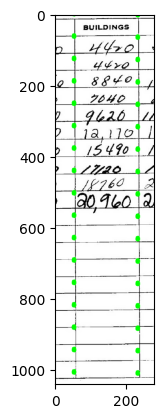

In [25]:
# Mark bounding boxes: final test
x = int(topleft[0])
y = int(topleft[1])
w = int(w_final)
h = int(h_final)
s = int(slant_final)

final_img = building_column_cropped

for i in range(20):
    final_img = cv2.circle(final_img, (x, y), 3, (0, 255, 0), 5)
    final_img = cv2.circle(final_img, (x+w, y+s), 3, (0, 255, 0), 5)
    final_img = cv2.circle(final_img, (x, y+h+s), 3, (0, 255, 0), 5)
    final_img = cv2.circle(final_img, (x+w, y+h+s), 3, (0, 255, 0), 5)
    y = y + h + s

plt.imshow(final_img)


ValueError: zero-size array to reduction operation minimum which has no identity

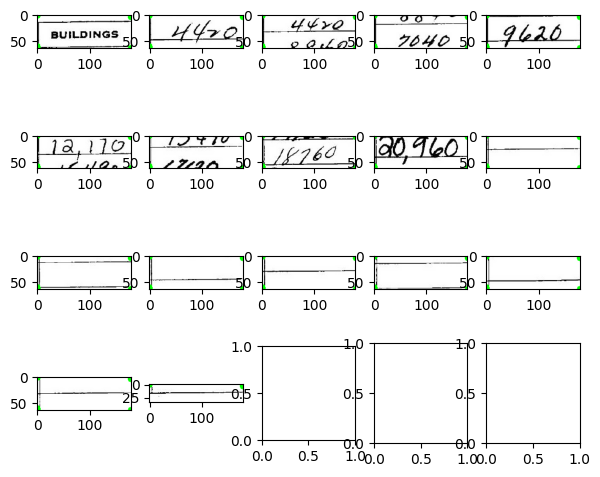

In [26]:
# Each individual box
x = int(topleft[0])
y = int(topleft[1])
w = int(w_final)
h = int(h_final)
s = int(slant_final)

fig, axes = plt.subplots(4, 5, figsize=(7, 6))
ax = axes.ravel()

for i in range(20):
    output = building_column_cropped[y:y+h+s, x:x+w]
    y = y + h + s
    ax[i].imshow(output)


In [209]:

    
    y = y + h + s

17 lines were detected


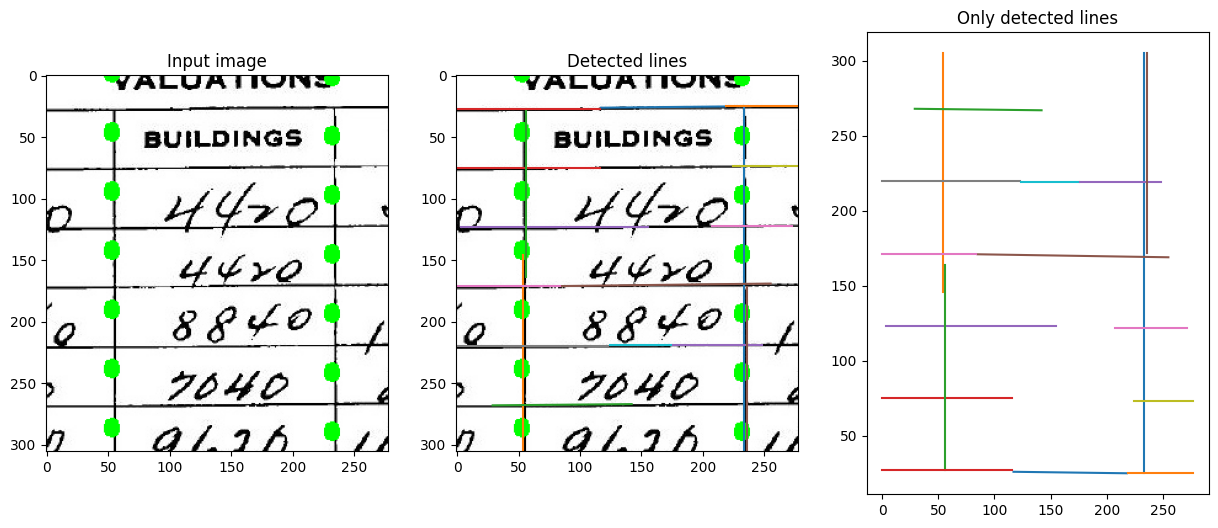

In [210]:
## Probabilistic hough transform
threshold = 100
#line_length = 5
#line_gap = 3

lines = probabilistic_hough_line(edges, threshold)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(cropped_again)
ax[0].set_title('Input image')

ax[1].imshow(cropped_again)
ax[1].set_title('Detected lines')

for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))

ax[2].set_title('Only detected lines')
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

print(f'{len(lines)} lines were detected')
